In [1]:
import pandas as pd
import numpy as np
import pandas as pd
import numpy as np
from tensorflow.keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.optimizers import Adam
from keras.optimizers import Adam, SGD
import matplotlib.pyplot as plt
from tensorflow.keras.models import Model

from keras.models import Sequential
from keras.layers import Conv2D, BatchNormalization, MaxPooling2D, Dropout, Flatten, Dense
from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler, EarlyStopping
from keras.metrics import Precision, Recall
from keras.preprocessing import image


In [2]:
data = pd.read_csv('fer2013.csv')
data.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


In [3]:
def preprocess_data():
  # Convert the pixel strings to numpy arrays
  data['pixels'] = data['pixels'].apply(lambda x: np.array(x.split(), dtype='float32').reshape(48, 48, 1))

  # Normalize the pixel values
  data['pixels'] = data['pixels'] / 255.0

  # Split the data
  train_data = data[data['Usage'] == 'Training']
  val_data = data[data['Usage'] == 'PublicTest']
  test_data = data[data['Usage'] == 'PrivateTest']

  # Prepare the data for training
  X_train = np.stack(train_data['pixels'].values)
  y_train = to_categorical(train_data['emotion'].values)

  X_val = np.stack(val_data['pixels'].values)
  y_val = to_categorical(val_data['emotion'].values)

  X_test = np.stack(test_data['pixels'].values)
  y_test = to_categorical(test_data['emotion'].values)

  return X_train,y_train,X_val,y_val,X_test,y_test


def augment_data(X_train,y_train):
    # Define data augmentation for the training set
   image_generator = ImageDataGenerator(
      rotation_range=10,
      width_shift_range=0.1,
      height_shift_range=0.1,
      horizontal_flip=True
    )

   augmented_data = image_generator.flow(X_train, y_train, batch_size=32)
   return augmented_data


def convert_to_image(X,y):
  image_generator = ImageDataGenerator()
  image_data = image_generator.flow(X,y,batch_size = 32)
  return image_data



In [4]:
X_train,y_train,X_val,y_val,X_test,y_test = preprocess_data()

validation = convert_to_image(X_val,y_val)
test = convert_to_image(X_test,y_test)
train = augment_data(X_train,y_train)

In [5]:
def create_model(l32=True, l64=True, l128=True, filter_size = 3 ,l512=False, optimizer='Adam', learning_rate=0.001, loss='categorical_crossentropy'):
    model = Sequential()

    if l32:
        model.add(Conv2D(32, (filter_size, filter_size), activation='relu', input_shape=(48, 48, 1)))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.25))

    if l64:
        model.add(Conv2D(64, (filter_size, filter_size), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.25))

    if l128:
        model.add(Conv2D(128, (filter_size, filter_size), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.25))

    if l512:
        model.add(Conv2D(512, (filter_size, filter_size), activation='relu'))
        model.add(BatchNormalization())
        model.add(MaxPooling2D((2, 2)))
        model.add(Dropout(0.25))

    model.add(Flatten())
    model.add(Dense(512, activation='relu'))
    model.add(BatchNormalization())
    model.add(Dropout(0.5))

    model.add(Dense(7, activation='softmax'))

    # Select optimizer
    if optimizer == 'Adam':
        opt = Adam(learning_rate=learning_rate)
    elif optimizer == 'SGD':
        opt = SGD(learning_rate=learning_rate)

    model.compile(optimizer=opt,
                  loss=loss,
                  metrics=['accuracy', Precision(), Recall()])

    return model

In [6]:
def plot_training(history):
    # Create subplots for loss, accuracy, precision, and recall
    plt.figure(figsize=(16, 12))

    # Plot training & validation loss values
    plt.subplot(2, 2, 1)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='upper right')

    # Plot training & validation accuracy values
    plt.subplot(2, 2, 2)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='lower right')

    plt.tight_layout()
    plt.show()


def plot_filters(layer, layer_name):
    filters, biases = layer.get_weights()
    n_filters = filters.shape[-1]

    # Normalize filter values to 0-1 so we can visualize them
    f_min, f_max = filters.min(), filters.max()
    filters = (filters - f_min) / (f_max - f_min)

    # Plot filters
    fig, axs = plt.subplots(8, 8, figsize=(10, 10))
    fig.suptitle(layer_name)

    for i in range(8):
        for j in range(8):
            if i * 8 + j < n_filters:
                # Get the filter
                f = filters[:, :, 0, i * 8 + j]
                axs[i, j].imshow(f, cmap='viridis')
                axs[i, j].axis('off')

    plt.show()


In [9]:
def test_model(model):
  test_loss, test_accuracy, test_precision, test_recall = model.evaluate(test)

  print(f'Test Accuracy: {test_accuracy}')
  print(f'Test Precision: {test_precision}')
  print(f'Test Recall: {test_recall}')


def train_model_scheduler_early_callback(modelname, l32=True, l64=True, l128=True, filter_size=3, l512=False, optimizer='Adam', learning_rate=0.001, loss='categorical_crossentropy'):
    model = create_model(l32, l64, l128, filter_size, l512, optimizer, learning_rate, loss)
    print(model.summary())
    # Define early stopping
    early_stopping = EarlyStopping(monitor='val_loss', patience=15, restore_best_weights=True)

    # Train the model with the learning rate scheduler and early stopping
    training = model.fit(
        train,
        epochs=1,
        validation_data=validation,
        callbacks=[early_stopping]
    )

    plot_training(training)  # Assuming plot_training is a defined function to plot training history
    model.save(f'{modelname}.keras')

    test_model(model)

    conv_layers = [layer for layer in model.layers if 'conv' in layer.name]

    for conv_layer in conv_layers:
        plot_filters(conv_layer, conv_layer.name)
    

    return model


/Users/elifozkan/miniconda3/lib/python3.9/site-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 46, 46, 32)     │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 46, 46, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 23, 23, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 21, 21, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 21, 21, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 10, 10, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 8, 8, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 8, 8, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 4, 4, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 2048)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 512)            │     1,049,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │         3,591 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,148,295 (4.38 MB)

 Trainable params: 1,146,823 (4.37 MB)

 Non-trainable params: 1,472 (5.75 KB)

None
897/898 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step - accuracy: 0.2327 - loss: 2.3609 - precision_1: 0.2664 - recall_1: 0.1026

/Users/elifozkan/miniconda3/lib/python3.9/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


898/898 ━━━━━━━━━━━━━━━━━━━━ 39s 42ms/step - accuracy: 0.2328 - loss: 2.3602 - precision_1: 0.2665 - recall_1: 0.1026 - val_accuracy: 0.2689 - val_loss: 1.9140 - val_precision_1: 0.3002 - val_recall_1: 0.1362


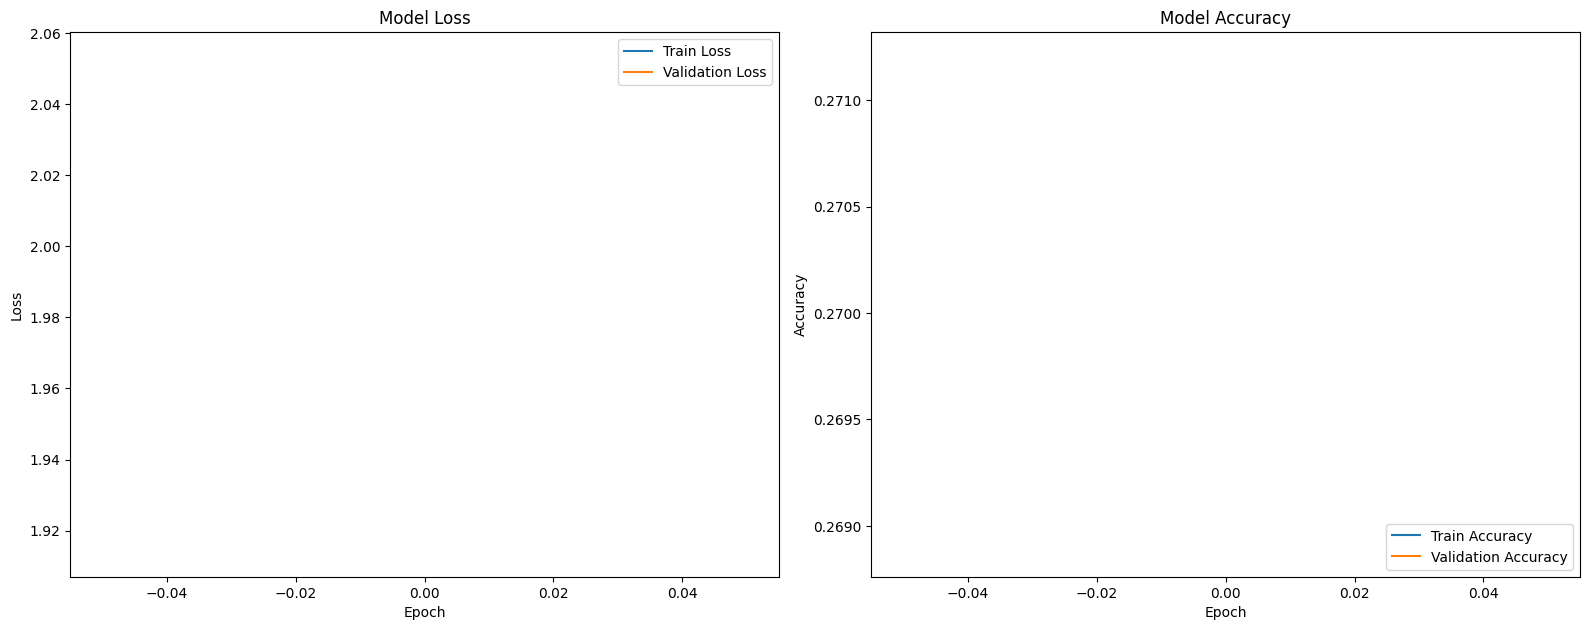

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2752 - loss: 1.9126 - precision_1: 0.3233 - recall_1: 0.1485
Test Accuracy: 0.2814154326915741
Test Precision: 0.3276073634624481
Test Recall: 0.1487879604101181


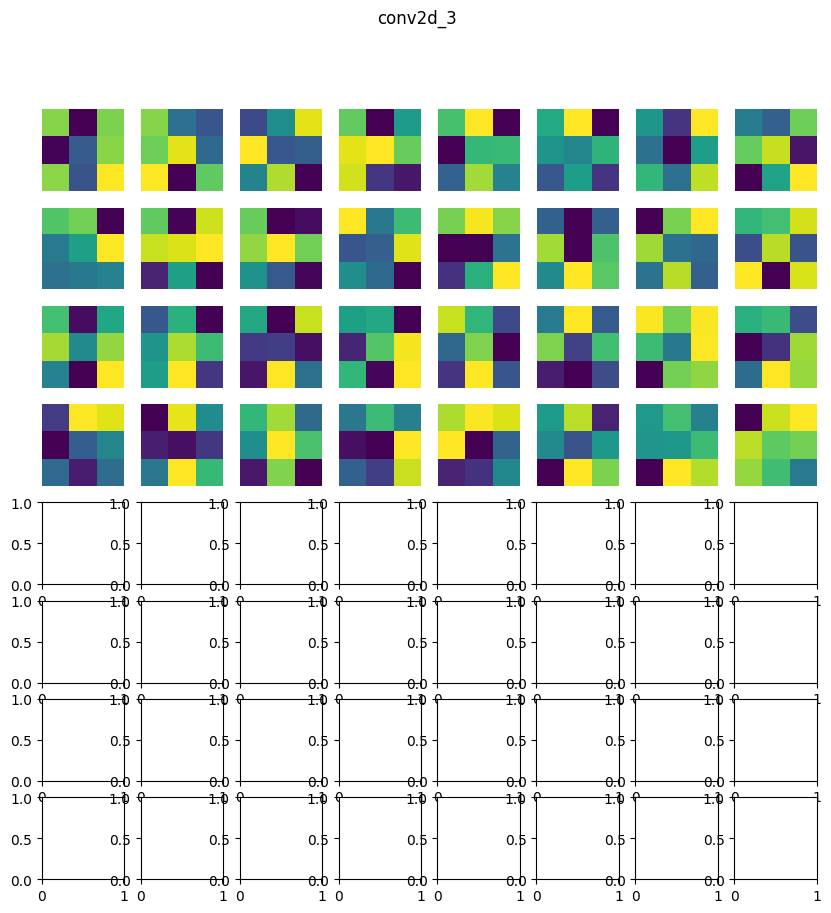

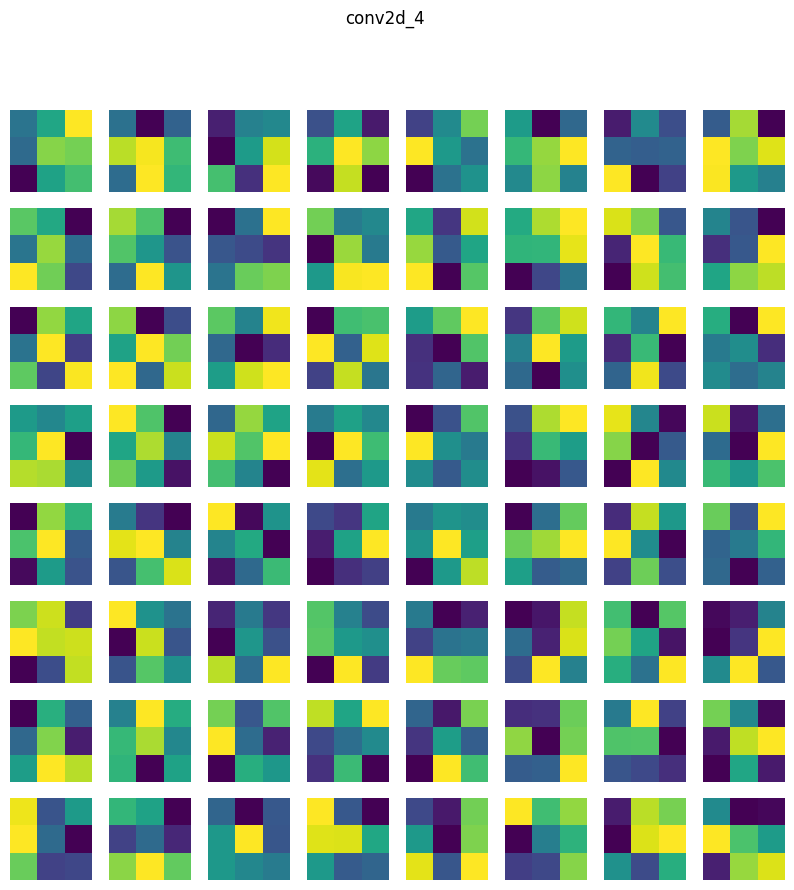

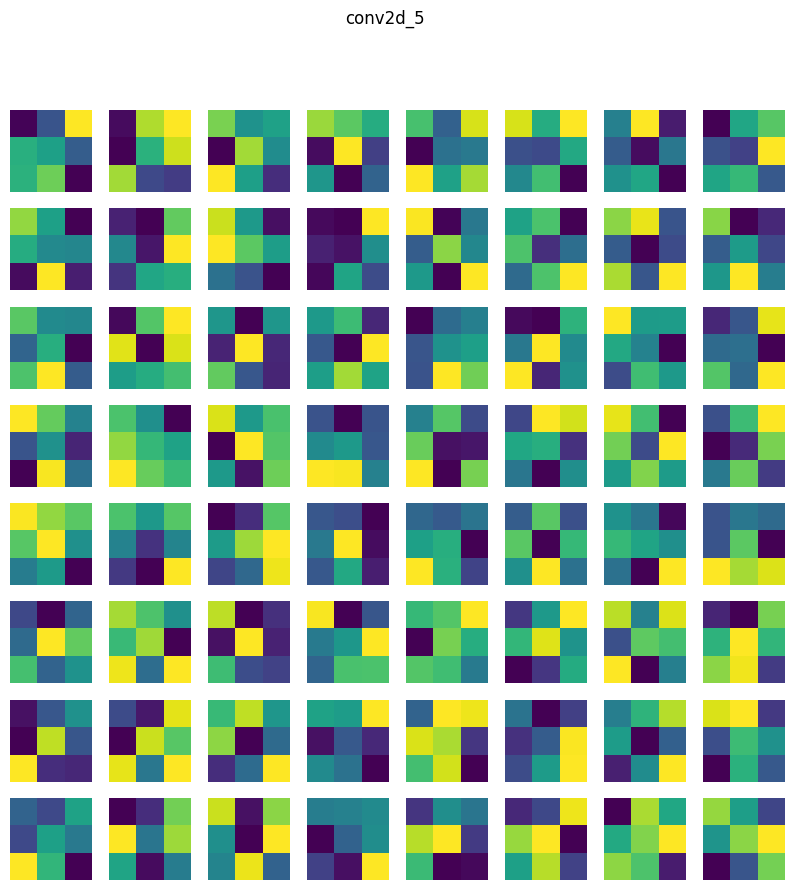

In [10]:
model = train_model_scheduler_early_callback("model128")

In [19]:
model.predict(X_test)

113/113 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step


array([[0.09542089, 0.01085279, 0.06627899, ..., 0.0911557 , 0.02629368,
        0.3668642 ],
       [0.01357331, 0.00122015, 0.06786647, ..., 0.14842469, 0.01486401,
        0.41847602],
       [0.14288394, 0.00574817, 0.10421869, ..., 0.31369916, 0.0121742 ,
        0.1646593 ],
       ...,
       [0.1419134 , 0.0190431 , 0.07881311, ..., 0.33081084, 0.0106311 ,
        0.22022378],
       [0.05721827, 0.00559423, 0.06589793, ..., 0.21646248, 0.01128503,
        0.28437686],
       [0.23306501, 0.01249353, 0.08412135, ..., 0.15354085, 0.01948473,
        0.2878366 ]], dtype=float32)